<a href="https://colab.research.google.com/github/idax6797/DeepLearning-MiniProject/blob/main/Notebooks/TransUnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [183]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from typing import Tuple, Dict, List
from PIL import Image

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.8.0+cu126


In [184]:
# from google.colab import drive
# drive.mount('/content/drive')

# TransUnet Architecture

In [185]:
class PatchEmbedding(nn.Module):
    """Split image into patches and embed them"""

    def __init__(self, img_size=256, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(in_channels, embed_dim,
                             kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/P, W/P)
        x = x.flatten(2)  # (B, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (B, n_patches, embed_dim)
        return x

In [186]:
class MultiHeadAttention(nn.Module):
    """Multi-head self-attention mechanism"""

    def __init__(self, embed_dim=768, num_heads=12, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape

        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.dropout(x)

        return x

In [187]:
class TransformerBlock(nn.Module):
    """Transformer encoder block"""

    def __init__(self, embed_dim=768, num_heads=12, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)

        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [188]:
class CNNEncoder(nn.Module):
    """CNN encoder for grayscale images"""

    def __init__(self, in_channels=1):
        super().__init__()

        # Custom encoder for grayscale images
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.conv2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.conv3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.conv4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        features = []
        x = self.conv1(x)  # (B, 64, H/2, W/2)
        features.append(x)

        x = self.conv2(x)  # (B, 256, H/4, W/4)
        features.append(x)

        x = self.conv3(x)  # (B, 512, H/8, W/8)
        features.append(x)

        x = self.conv4(x)  # (B, 1024, H/16, W/16)
        features.append(x)

        return features

In [189]:
class DecoderBlock(nn.Module):
    """Decoder block with skip connections"""

    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels,
                                        kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels + skip_channels, out_channels,
                     kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip):
        x = self.upconv(x)
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return x

In [190]:
class TransUNet(nn.Module):
    """TransUNet architecture for medical image segmentation"""

    def __init__(self, img_size=256, patch_size=16, in_channels=1,
                 num_classes=1, embed_dim=768, num_heads=12,
                 num_layers=12, mlp_ratio=4, dropout=0.1):
        super().__init__()

        # Validate that embed_dim is divisible by num_heads
        assert embed_dim % num_heads == 0, f"embed_dim ({embed_dim}) must be divisible by num_heads ({num_heads})"

        # CNN Encoder
        self.cnn_encoder = CNNEncoder(in_channels=in_channels)

        # Patch embedding
        self.patch_embed = PatchEmbedding(
            img_size=img_size//16, patch_size=1,
            in_channels=1024, embed_dim=embed_dim
        )

        # Transformer encoder
        self.transformer = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(num_layers)
        ])

        self.norm = nn.LayerNorm(embed_dim)

        # Bridge to decoder
        self.conv_bridge = nn.Conv2d(embed_dim, 512, kernel_size=1)

        # Decoder
        self.decoder4 = DecoderBlock(512, 512, 256)
        self.decoder3 = DecoderBlock(256, 256, 128)
        self.decoder2 = DecoderBlock(128, 64, 64)
        self.decoder1 = DecoderBlock(64, 64, 32)
        # Upsample to original size
        self.final_upsample = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        # Final output
        self.final = nn.Sequential(
            nn.Conv2d(64, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, num_classes, kernel_size=1)
        )

    def forward(self, x):
        # CNN encoder
        features = self.cnn_encoder(x)

        # Transformer encoder
        x_transformer = self.patch_embed(features[3])
        for block in self.transformer:
            x_transformer = block(x_transformer)
        x_transformer = self.norm(x_transformer)

        # Reshape transformer output
        B, N, C = x_transformer.shape
        H = W = int(N ** 0.5)
        x_transformer = x_transformer.transpose(1, 2).reshape(B, C, H, W)
        x_transformer = self.conv_bridge(x_transformer)

        # Decoder with skip connections
        x = self.decoder4(x_transformer, features[2]) # (16x16) -> (32x32) + features[2]
        x = self.decoder3(x, features[1]) # (32x32) -> (64x64) + features[1](64x64)
        x = self.decoder2(x, features[0]) # (64x64) -> (128x128) + features[0](128x128)

        # Upsample to original size
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)

        # Final output
        x = self.final(x)

        return x

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [191]:
#Initialize model
transunet = TransUNet(img_size=256, patch_size=16, in_channels=1, num_classes=1, embed_dim=768, num_heads=12, num_layers=12, mlp_ratio=4, dropout=0.1).to(device)
num_params = transunet.count_parameters()
print(f"Number of trainable parameters in TransUNet: {num_params}")

Number of trainable parameters in TransUNet: 108156081


# Metrics and Loss Functions

In [192]:
def dice_coefficient(pred, target, threshold=0.5, epsilon=1e-7):
    """Compute Dice coefficient"""
    pred_binary = (pred > threshold).float()
    target_binary = (target > threshold).float()

    intersection = (pred_binary * target_binary).sum()
    union = pred_binary.sum() + target_binary.sum()

    dice = (2.0 * intersection) / (union + epsilon)
    return dice.item()

In [193]:
def iou_score(pred, target, threshold=0.5, epsilon=1e-7):
    """Compute IoU (Intersection over Union)"""
    pred_binary = (pred > threshold).float()
    target_binary = (target > threshold).float()

    intersection = (pred_binary * target_binary).sum()
    union = pred_binary.sum() + target_binary.sum() - intersection

    iou = intersection / (union + epsilon)
    return iou.item()

In [194]:
class DiceLoss(nn.Module):
    """Dice loss for segmentation"""

    def __init__(self, smooth=1e-5):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)

        intersection = (pred * target).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))

        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

In [195]:
class CombinedLoss(nn.Module):
    """Combined BCE and Dice loss"""

    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super().__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        dice_loss = self.dice(pred, target)
        return self.bce_weight * bce_loss + self.dice_weight * dice_loss

# Training Setup

In [196]:
# Training configuration
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4

# Optimizer
optimizer = torch.optim.AdamW(transunet.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Loss function: BCE for segmentation
#seg_criterion = nn.BCEWithLogitsLoss()

seg_criterion = CombinedLoss()

# Training history
history = {
    'train_loss': [],
    'train_dice': [],
    'train_iou': [],
    'val_loss': [],
    'val_dice': [],
    'val_iou': [],
    'epoch_times': []
}

print("✓ Training configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Loss: Combined BCE + Dice")
print(f"  Metrics: Dice, IoU, BCE")
print(f"  Optimizer: Adam with weight decay={1e-5}")

✓ Training configuration:
  Epochs: 50
  Learning rate: 0.0001
  Loss: Combined BCE + Dice
  Metrics: Dice, IoU, BCE
  Optimizer: Adam with weight decay=1e-05


In [197]:
def train_epoch(model, dataloader, optimizer, epoch):
    """Train for one epoch"""
    model.train()
    epoch_loss = []
    epoch_dice = []
    epoch_iou = []

    pbar = tqdm(dataloader, desc=f"Epoch {epoch} [Train]")
    for images, masks, _ in pbar:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)

        #Compute Loss
        loss = seg_criterion(outputs, masks)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Compute metrics
        seg_probs = torch.sigmoid(outputs)
        dice = dice_coefficient(seg_probs, masks)
        iou = iou_score(seg_probs, masks)

        # Track metrics
        epoch_loss.append(loss.item())
        epoch_dice.append(dice)
        epoch_iou.append(iou)

        # Update progress
        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'dice': f"{dice:.4f}",
            'iou': f"{iou:.4f}"
        })

    return {
        'loss': np.mean(epoch_loss),
        'dice': np.mean(epoch_dice),
        'iou': np.mean(epoch_iou)
    }

In [198]:
def validate_epoch(model, dataloader, epoch):
    model.eval()
    val_loss, val_dice, val_iou = [], [], []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc=f"Epoch {epoch} [Val]")
        for images, masks, _ in pbar:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            if isinstance(outputs, list):
                losses = [seg_criterion(o, masks) for o in outputs]
                loss = sum(losses) / len(losses)
                seg_logits = outputs[-1]
            else:
                seg_logits = outputs
                loss = seg_criterion(seg_logits, masks)

            seg_probs = torch.sigmoid(seg_logits)
            dice = dice_coefficient(seg_probs, masks)
            iou = iou_score(seg_probs, masks)

            val_loss.append(loss.item())
            val_dice.append(dice)
            val_iou.append(iou)

            pbar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "dice": f"{dice:.4f}",
                "iou": f"{iou:.4f}"
            })

    return {
        "loss": np.mean(val_loss),
        "dice": np.mean(val_dice),
        "iou": np.mean(val_iou)
    }

# Load Data

In [199]:
class PreSplitTumorDataset(Dataset):
    """Dataset for loading pre-split train/val/test data"""
    def __init__(self, data_dir: str, split='train'):
        """
        Args:
            data_dir: Path to preprocessed_data directory
            split: 'train', 'val', or 'test'
        """
        self.data_dir = Path(data_dir) / split
        self.split = split

        print(f"\n{'='*70}")
        print("Loading {split.upper()} dataset from: {self.data_dir}")
        print(f"{'='*70}")

        if not self.data_dir.exists():
            raise FileNotFoundError(f"Split directory not found: {self.data_dir}")

        self.samples = []

        control_dir = self.data_dir / 'controls' / 'imgs'
        patient_img_dir = self.data_dir / 'patients' / 'imgs'
        patient_label_dir = self.data_dir / 'patients' / 'labels'

        print(f"  Controls dir: {control_dir.exists()}")
        print(f"  Patients dir: {patient_img_dir.exists()}")
        print(f"  Labels dir: {patient_label_dir.exists()}")

        if control_dir.exists():
            control_files = sorted(list(control_dir.glob('*.png')))
            print(f"\n  Found {len(control_files)} control images")
            for img_path in control_files:
                self.samples.append((img_path, None, 0))

        if patient_img_dir.exists() and patient_label_dir.exists():
            patient_files = sorted(list(patient_img_dir.glob('*.png')))
            print(f"  Found {len(patient_files)} patient images")

            matched = 0
            for img_path in patient_files:
                img_stem = img_path.stem

                possible_label_names = [
                    img_path.name,
                    img_stem + '.png',
                    img_stem.replace('patient_', 'segmentation_') + '.png',
                ]

                label_path = None
                for label_name in possible_label_names:
                    test_path = patient_label_dir / label_name
                    if test_path.exists():
                        label_path = test_path
                        break

                if label_path:
                    self.samples.append((img_path, label_path, 1))
                    matched += 1

            print(f"  Matched {matched} patient images with labels")

        num_controls = len([s for s in self.samples if s[2] == 0])
        num_patients = len([s for s in self.samples if s[2] == 1])

        print(f"\n{'='*70}")
        print(f"{split.upper()} SET SUMMARY")
        print(f"{'='*70}")
        print(f"  Controls: {num_controls}")
        print(f"  Patients: {num_patients}")
        print(f"  Total: {len(self.samples)}")
        print(f"  Tumor ratio: {num_patients/len(self.samples)*100:.1f}%")
        print(f"{'='*70}\n")

        if len(self.samples) == 0:
            raise ValueError(f"No samples found in {self.data_dir}")

    def __len__(self):
        return len(self.samples)

    def _load_image(self, path: Path) -> np.ndarray:
        """Load PNG image and convert to grayscale numpy array"""
        img = Image.open(path).convert('L')
        return np.array(img)

    def __getitem__(self, idx):
        img_path, label_path, has_tumor = self.samples[idx]

        image = self._load_image(img_path)

        if image.max() > 1.0:
            image = image / 255.0

        if label_path and label_path.exists():
            mask = self._load_image(label_path)
            if mask.max() > 1.0:
                mask = mask / 255.0
        else:
            mask = np.zeros_like(image)

        if image.ndim == 2:
            image = image[np.newaxis, ...]
        if mask.ndim == 2:
            mask = mask[np.newaxis, ...]

        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).float()
        clf_label = torch.tensor(has_tumor, dtype=torch.long)

        return image, mask, clf_label


print("="*70)
print("LOADING PRE-SPLIT MIP-PET TUMOR DATASET")
print("="*70)

possible_paths = [
    Path('/content/drive/MyDrive/preprocessed_data'),
]

DATA_DIR = None
for path in possible_paths:
    print(f"\nChecking: {path}")
    if path.exists():
        has_train = (path / 'train').exists()
        has_val = (path / 'val').exists()
        has_test = (path / 'test').exists()

        print(f"   Train folder: {has_train}")
        print(f"   Val folder: {has_val}")
        print(f"   Test folder: {has_test}")

        if has_train and has_val and has_test:
            DATA_DIR = path
            print(f"   ✅ Using this directory!")
            break
    else:
        print(f"Directory doesn't exist")

if DATA_DIR is None:
    raise FileNotFoundError("Pre-split data directory not found! Please run EDA.ipynb first to create splits.")

print(f"\n{'='*70}")
print(f"Final data directory: {DATA_DIR}")
print(f"{'='*70}\n")

train_dataset = PreSplitTumorDataset(str(DATA_DIR), split='train')
val_dataset = PreSplitTumorDataset(str(DATA_DIR), split='val')
test_dataset = PreSplitTumorDataset(str(DATA_DIR), split='test')

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\n{'='*70}")
print(f"✅ DATALOADERS CREATED")
print(f"{'='*70}")
print(f"  Train batches: {len(train_loader)} ({len(train_dataset)} samples)")
print(f"  Val batches: {len(val_loader)} ({len(val_dataset)} samples)")
print(f"  Test batches: {len(test_loader)} ({len(test_dataset)} samples)")
print(f"{'='*70}\n")

LOADING PRE-SPLIT MIP-PET TUMOR DATASET

Checking: /content/drive/MyDrive/preprocessed_data
   Train folder: True
   Val folder: True
   Test folder: True
   ✅ Using this directory!

Final data directory: /content/drive/MyDrive/preprocessed_data


Loading {split.upper()} dataset from: {self.data_dir}
  Controls dir: True
  Patients dir: True
  Labels dir: True

  Found 298 control images
  Found 127 patient images
  Matched 127 patient images with labels

TRAIN SET SUMMARY
  Controls: 298
  Patients: 127
  Total: 425
  Tumor ratio: 29.9%


Loading {split.upper()} dataset from: {self.data_dir}
  Controls dir: True
  Patients dir: True
  Labels dir: True

  Found 64 control images
  Found 27 patient images
  Matched 27 patient images with labels

VAL SET SUMMARY
  Controls: 64
  Patients: 27
  Total: 91
  Tumor ratio: 29.7%


Loading {split.upper()} dataset from: {self.data_dir}
  Controls dir: True
  Patients dir: True
  Labels dir: True

  Found 64 control images
  Found 28 patient ima

# Train Model

In [200]:
import time
training_start = time.time()
best_val_dice = 0.0
for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start = time.time()

    # Train
    train_metrics = train_epoch(transunet, train_loader, optimizer, epoch)

    # Validate
    val_metrics = validate_epoch(transunet, val_loader, epoch)

    # Track history
    history['train_loss'].append(train_metrics['loss'])
    history['train_dice'].append(train_metrics['dice'])
    history['train_iou'].append(train_metrics['iou'])
    history['val_loss'].append(val_metrics['loss'])
    history['val_dice'].append(val_metrics['dice'])
    history['val_iou'].append(val_metrics['iou'])

    epoch_time = time.time() - epoch_start
    history['epoch_times'].append(epoch_time)

    # Print summary
    print(f"\nEpoch {epoch}/{NUM_EPOCHS} Summary:")
    print(f"  Train - Loss: {train_metrics['loss']:.4f}, Dice: {train_metrics['dice']:.4f}, IoU: {train_metrics['iou']:.4f}")
    print(f"  Val   - Loss: {val_metrics['loss']:.4f}, Dice: {val_metrics['dice']:.4f}, IoU: {val_metrics['iou']:.4f}")
    print(f"  Time: {epoch_time:.1f}s")

    # Save best model
    if val_metrics['dice'] > best_val_dice:
        best_val_dice = val_metrics['dice']
        torch.save(transunet.state_dict(), 'best_transunet_segmentation.pth')
        print(f"  ✓ New best model saved! (Dice: {best_val_dice:.4f})")

training_time = time.time() - training_start

print("\n" + "="*70)
print("🎓 SEGMENTATION TRAINING COMPLETE!")
print("="*70)
print(f"Total training time: {training_time:.1f}s ({training_time/60:.1f} minutes)")
print(f"Average epoch time: {np.mean(history['epoch_times']):.1f}s")
print(f"Best validation Dice: {best_val_dice:.4f}")

# Load best model
transunet.load_state_dict(torch.load('best_transunet_segmentation.pth'))
print("\n✓ Best model loaded for evaluation!")

Epoch 1 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.55it/s, loss=0.7781, dice=0.0990, iou=0.0521]



Epoch 1/50 Summary:
  Train - Loss: 0.8141, Dice: 0.0564, IoU: 0.0307
  Val   - Loss: 0.7850, Dice: 0.0203, IoU: 0.0105
  Time: 37.0s
  ✓ New best model saved! (Dice: 0.0203)


Epoch 2 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.65it/s, loss=0.7539, dice=0.2618, iou=0.1506]



Epoch 2/50 Summary:
  Train - Loss: 0.7737, Dice: 0.1027, IoU: 0.0566
  Val   - Loss: 0.7610, Dice: 0.1039, IoU: 0.0617
  Time: 35.6s
  ✓ New best model saved! (Dice: 0.1039)


Epoch 3 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.67it/s, loss=0.7394, dice=0.3269, iou=0.1954]



Epoch 3/50 Summary:
  Train - Loss: 0.7534, Dice: 0.2359, IoU: 0.1448
  Val   - Loss: 0.7488, Dice: 0.1267, IoU: 0.0795
  Time: 35.6s
  ✓ New best model saved! (Dice: 0.1267)


Epoch 4 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.62it/s, loss=0.7313, dice=0.4389, iou=0.2812]



Epoch 4/50 Summary:
  Train - Loss: 0.7450, Dice: 0.2570, IoU: 0.1654
  Val   - Loss: 0.7387, Dice: 0.1816, IoU: 0.1256
  Time: 35.8s
  ✓ New best model saved! (Dice: 0.1816)


Epoch 5 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.70it/s, loss=0.7243, dice=0.4703, iou=0.3075]



Epoch 5/50 Summary:
  Train - Loss: 0.7378, Dice: 0.3313, IoU: 0.2180
  Val   - Loss: 0.7333, Dice: 0.1687, IoU: 0.1133
  Time: 35.6s


Epoch 6 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.66it/s, loss=0.7208, dice=0.3200, iou=0.1905]



Epoch 6/50 Summary:
  Train - Loss: 0.7322, Dice: 0.3287, IoU: 0.2233
  Val   - Loss: 0.7286, Dice: 0.1352, IoU: 0.0854
  Time: 35.5s


Epoch 7 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.52it/s, loss=0.7129, dice=0.5559, iou=0.3850]



Epoch 7/50 Summary:
  Train - Loss: 0.7267, Dice: 0.3756, IoU: 0.2537
  Val   - Loss: 0.7237, Dice: 0.2059, IoU: 0.1495
  Time: 35.7s
  ✓ New best model saved! (Dice: 0.2059)


Epoch 8 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.56it/s, loss=0.7099, dice=0.3782, iou=0.2332]



Epoch 8/50 Summary:
  Train - Loss: 0.7216, Dice: 0.4166, IoU: 0.2898
  Val   - Loss: 0.7183, Dice: 0.1900, IoU: 0.1363
  Time: 35.6s


Epoch 9 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.66it/s, loss=0.7245, dice=0.3064, iou=0.1809]



Epoch 9/50 Summary:
  Train - Loss: 0.7171, Dice: 0.4543, IoU: 0.3197
  Val   - Loss: 0.7292, Dice: 0.1166, IoU: 0.0719
  Time: 35.7s


Epoch 10 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.68it/s, loss=0.7019, dice=0.4042, iou=0.2533]



Epoch 10/50 Summary:
  Train - Loss: 0.7135, Dice: 0.4294, IoU: 0.3026
  Val   - Loss: 0.7108, Dice: 0.1880, IoU: 0.1337
  Time: 35.8s


Epoch 11 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.36it/s, loss=0.6961, dice=0.5628, iou=0.3916]



Epoch 11/50 Summary:
  Train - Loss: 0.7093, Dice: 0.4388, IoU: 0.3104
  Val   - Loss: 0.7067, Dice: 0.1909, IoU: 0.1347
  Time: 36.1s


Epoch 12 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.60it/s, loss=0.6879, dice=0.6173, iou=0.4465]



Epoch 12/50 Summary:
  Train - Loss: 0.7042, Dice: 0.5169, IoU: 0.3761
  Val   - Loss: 0.7027, Dice: 0.2177, IoU: 0.1618
  Time: 35.9s
  ✓ New best model saved! (Dice: 0.2177)


Epoch 13 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.66it/s, loss=0.6864, dice=0.6058, iou=0.4346]



Epoch 13/50 Summary:
  Train - Loss: 0.6999, Dice: 0.5285, IoU: 0.3974
  Val   - Loss: 0.7010, Dice: 0.2181, IoU: 0.1623
  Time: 35.8s
  ✓ New best model saved! (Dice: 0.2181)


Epoch 14 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.59it/s, loss=0.6802, dice=0.5720, iou=0.4006]



Epoch 14/50 Summary:
  Train - Loss: 0.6958, Dice: 0.5629, IoU: 0.4287
  Val   - Loss: 0.6958, Dice: 0.1989, IoU: 0.1420
  Time: 36.3s


Epoch 15 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.52it/s, loss=0.6765, dice=0.6270, iou=0.4566]



Epoch 15/50 Summary:
  Train - Loss: 0.6929, Dice: 0.4972, IoU: 0.3687
  Val   - Loss: 0.6907, Dice: 0.2316, IoU: 0.1779
  Time: 35.8s
  ✓ New best model saved! (Dice: 0.2316)


Epoch 16 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.65it/s, loss=0.6749, dice=0.4916, iou=0.3259]



Epoch 16/50 Summary:
  Train - Loss: 0.6882, Dice: 0.5683, IoU: 0.4354
  Val   - Loss: 0.6928, Dice: 0.1727, IoU: 0.1174
  Time: 35.6s


Epoch 17 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.60it/s, loss=0.6716, dice=0.5312, iou=0.3616]



Epoch 17/50 Summary:
  Train - Loss: 0.6846, Dice: 0.5584, IoU: 0.4249
  Val   - Loss: 0.6868, Dice: 0.2021, IoU: 0.1462
  Time: 35.8s


Epoch 18 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.48it/s, loss=0.6653, dice=0.6506, iou=0.4821]



Epoch 18/50 Summary:
  Train - Loss: 0.6807, Dice: 0.5583, IoU: 0.4251
  Val   - Loss: 0.6804, Dice: 0.2348, IoU: 0.1816
  Time: 35.8s
  ✓ New best model saved! (Dice: 0.2348)


Epoch 19 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.56it/s, loss=0.6584, dice=0.6949, iou=0.5324]



Epoch 19/50 Summary:
  Train - Loss: 0.6767, Dice: 0.6147, IoU: 0.4771
  Val   - Loss: 0.6767, Dice: 0.2145, IoU: 0.1589
  Time: 35.8s


Epoch 20 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.70it/s, loss=0.6900, dice=0.3014, iou=0.1774]



Epoch 20/50 Summary:
  Train - Loss: 0.6737, Dice: 0.5389, IoU: 0.4127
  Val   - Loss: 0.6873, Dice: 0.1186, IoU: 0.0735
  Time: 35.8s


Epoch 21 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.65it/s, loss=0.6531, dice=0.5619, iou=0.3907]



Epoch 21/50 Summary:
  Train - Loss: 0.6695, Dice: 0.5429, IoU: 0.4174
  Val   - Loss: 0.6710, Dice: 0.2003, IoU: 0.1445
  Time: 35.7s


Epoch 22 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.54it/s, loss=0.6457, dice=0.6014, iou=0.4300]



Epoch 22/50 Summary:
  Train - Loss: 0.6659, Dice: 0.5947, IoU: 0.4554
  Val   - Loss: 0.6648, Dice: 0.2208, IoU: 0.1656
  Time: 35.7s


Epoch 23 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.66it/s, loss=0.6423, dice=0.6389, iou=0.4694]



Epoch 23/50 Summary:
  Train - Loss: 0.6617, Dice: 0.5834, IoU: 0.4506
  Val   - Loss: 0.6616, Dice: 0.2258, IoU: 0.1710
  Time: 35.7s


Epoch 24 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.64it/s, loss=0.6331, dice=0.6790, iou=0.5140]



Epoch 24/50 Summary:
  Train - Loss: 0.6579, Dice: 0.5955, IoU: 0.4665
  Val   - Loss: 0.6563, Dice: 0.2288, IoU: 0.1743
  Time: 35.8s


Epoch 25 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.51it/s, loss=0.6293, dice=0.7491, iou=0.5989]



Epoch 25/50 Summary:
  Train - Loss: 0.6542, Dice: 0.6590, IoU: 0.5299
  Val   - Loss: 0.6523, Dice: 0.2441, IoU: 0.1926
  Time: 35.8s
  ✓ New best model saved! (Dice: 0.2441)


Epoch 26 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.63it/s, loss=0.6193, dice=0.6961, iou=0.5339]



Epoch 26/50 Summary:
  Train - Loss: 0.6504, Dice: 0.6927, IoU: 0.5585
  Val   - Loss: 0.6471, Dice: 0.2301, IoU: 0.1760
  Time: 36.4s


Epoch 27 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.65it/s, loss=0.6293, dice=0.6293, iou=0.4591]



Epoch 27/50 Summary:
  Train - Loss: 0.6469, Dice: 0.6960, IoU: 0.5604
  Val   - Loss: 0.6463, Dice: 0.2091, IoU: 0.1527
  Time: 35.8s


Epoch 28 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.51it/s, loss=0.6220, dice=0.7006, iou=0.5392]



Epoch 28/50 Summary:
  Train - Loss: 0.6435, Dice: 0.6942, IoU: 0.5600
  Val   - Loss: 0.6435, Dice: 0.2374, IoU: 0.1845
  Time: 35.9s


Epoch 29 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.65it/s, loss=0.6207, dice=0.5601, iou=0.3890]



Epoch 29/50 Summary:
  Train - Loss: 0.6399, Dice: 0.6897, IoU: 0.5678
  Val   - Loss: 0.6464, Dice: 0.2063, IoU: 0.1512
  Time: 35.7s


Epoch 30 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.67it/s, loss=0.6028, dice=0.5113, iou=0.3435]



Epoch 30/50 Summary:
  Train - Loss: 0.6366, Dice: 0.6668, IoU: 0.5462
  Val   - Loss: 0.6336, Dice: 0.1967, IoU: 0.1412
  Time: 35.7s


Epoch 31 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.48it/s, loss=0.6045, dice=0.6059, iou=0.4346]



Epoch 31/50 Summary:
  Train - Loss: 0.6329, Dice: 0.7397, IoU: 0.6092
  Val   - Loss: 0.6317, Dice: 0.2268, IoU: 0.1729
  Time: 35.9s


Epoch 32 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.58it/s, loss=0.5822, dice=0.6263, iou=0.4559]



Epoch 32/50 Summary:
  Train - Loss: 0.6287, Dice: 0.6974, IoU: 0.5806
  Val   - Loss: 0.6310, Dice: 0.2204, IoU: 0.1651
  Time: 35.7s


Epoch 33 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.67it/s, loss=0.5959, dice=0.6669, iou=0.5002]



Epoch 33/50 Summary:
  Train - Loss: 0.6263, Dice: 0.6800, IoU: 0.5520
  Val   - Loss: 0.6255, Dice: 0.2380, IoU: 0.1853
  Time: 35.8s


Epoch 34 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.62it/s, loss=0.5982, dice=0.7016, iou=0.5404]



Epoch 34/50 Summary:
  Train - Loss: 0.6229, Dice: 0.7341, IoU: 0.6073
  Val   - Loss: 0.6264, Dice: 0.2395, IoU: 0.1869
  Time: 35.8s


Epoch 35 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.58it/s, loss=0.5932, dice=0.5188, iou=0.3502]



Epoch 35/50 Summary:
  Train - Loss: 0.6213, Dice: 0.6512, IoU: 0.5180
  Val   - Loss: 0.6184, Dice: 0.1788, IoU: 0.1228
  Time: 35.7s


Epoch 36 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.63it/s, loss=0.5698, dice=0.6095, iou=0.4384]



Epoch 36/50 Summary:
  Train - Loss: 0.6189, Dice: 0.5954, IoU: 0.4642
  Val   - Loss: 0.5973, Dice: 0.2268, IoU: 0.1726
  Time: 35.7s


Epoch 37 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.68it/s, loss=0.5934, dice=0.6102, iou=0.4390]



Epoch 37/50 Summary:
  Train - Loss: 0.6140, Dice: 0.6146, IoU: 0.4958
  Val   - Loss: 0.6181, Dice: 0.2255, IoU: 0.1708
  Time: 35.7s


Epoch 38 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.48it/s, loss=0.5740, dice=0.6396, iou=0.4702]



Epoch 38/50 Summary:
  Train - Loss: 0.6105, Dice: 0.7076, IoU: 0.5797
  Val   - Loss: 0.6108, Dice: 0.2303, IoU: 0.1762
  Time: 35.8s


Epoch 39 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.63it/s, loss=0.5881, dice=0.3859, iou=0.2391]



Epoch 39/50 Summary:
  Train - Loss: 0.6071, Dice: 0.7241, IoU: 0.5952
  Val   - Loss: 0.6112, Dice: 0.1529, IoU: 0.0999
  Time: 35.7s


Epoch 40 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.68it/s, loss=0.5907, dice=0.5566, iou=0.3856]



Epoch 40/50 Summary:
  Train - Loss: 0.6038, Dice: 0.7329, IoU: 0.6090
  Val   - Loss: 0.6132, Dice: 0.1937, IoU: 0.1372
  Time: 35.8s


Epoch 41 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.44it/s, loss=0.5569, dice=0.7016, iou=0.5403]



Epoch 41/50 Summary:
  Train - Loss: 0.6014, Dice: 0.6854, IoU: 0.5687
  Val   - Loss: 0.5938, Dice: 0.2422, IoU: 0.1906
  Time: 35.9s


Epoch 42 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.62it/s, loss=0.5918, dice=0.4700, iou=0.3072]



Epoch 42/50 Summary:
  Train - Loss: 0.5978, Dice: 0.6877, IoU: 0.5756
  Val   - Loss: 0.6062, Dice: 0.2003, IoU: 0.1446
  Time: 35.8s


Epoch 43 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.63it/s, loss=0.5411, dice=0.6627, iou=0.4956]



Epoch 43/50 Summary:
  Train - Loss: 0.5950, Dice: 0.7354, IoU: 0.6152
  Val   - Loss: 0.6060, Dice: 0.2200, IoU: 0.1643
  Time: 35.8s


Epoch 44 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.46it/s, loss=0.5290, dice=0.6525, iou=0.4843]



Epoch 44/50 Summary:
  Train - Loss: 0.5920, Dice: 0.7449, IoU: 0.6248
  Val   - Loss: 0.5766, Dice: 0.2313, IoU: 0.1773
  Time: 35.8s


Epoch 45 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.62it/s, loss=0.5125, dice=0.7383, iou=0.5852]



Epoch 45/50 Summary:
  Train - Loss: 0.5895, Dice: 0.7090, IoU: 0.5867
  Val   - Loss: 0.5832, Dice: 0.2401, IoU: 0.1877
  Time: 35.7s


Epoch 46 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.63it/s, loss=0.5839, dice=0.3443, iou=0.2080]



Epoch 46/50 Summary:
  Train - Loss: 0.5861, Dice: 0.7718, IoU: 0.6442
  Val   - Loss: 0.5968, Dice: 0.1896, IoU: 0.1363
  Time: 35.8s


Epoch 47 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.57it/s, loss=0.5421, dice=0.6384, iou=0.4689]



Epoch 47/50 Summary:
  Train - Loss: 0.5835, Dice: 0.7606, IoU: 0.6437
  Val   - Loss: 0.5832, Dice: 0.2240, IoU: 0.1689
  Time: 35.8s


Epoch 48 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.68it/s, loss=0.5655, dice=0.5987, iou=0.4272]



Epoch 48/50 Summary:
  Train - Loss: 0.5802, Dice: 0.7644, IoU: 0.6499
  Val   - Loss: 0.5903, Dice: 0.2213, IoU: 0.1661
  Time: 35.6s


Epoch 49 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.70it/s, loss=0.5226, dice=0.6942, iou=0.5316]



Epoch 49/50 Summary:
  Train - Loss: 0.5768, Dice: 0.7866, IoU: 0.6760
  Val   - Loss: 0.5812, Dice: 0.2324, IoU: 0.1787
  Time: 35.7s


Epoch 50 [Val]: 100%|██████████| 12/12 [00:02<00:00,  4.56it/s, loss=0.4580, dice=0.5100, iou=0.3423]



Epoch 50/50 Summary:
  Train - Loss: 0.5740, Dice: 0.7509, IoU: 0.6397
  Val   - Loss: 0.5503, Dice: 0.2003, IoU: 0.1445
  Time: 35.8s

🎓 SEGMENTATION TRAINING COMPLETE!
Total training time: 1808.2s (30.1 minutes)
Average epoch time: 35.8s
Best validation Dice: 0.2441

✓ Best model loaded for evaluation!


# Visualization

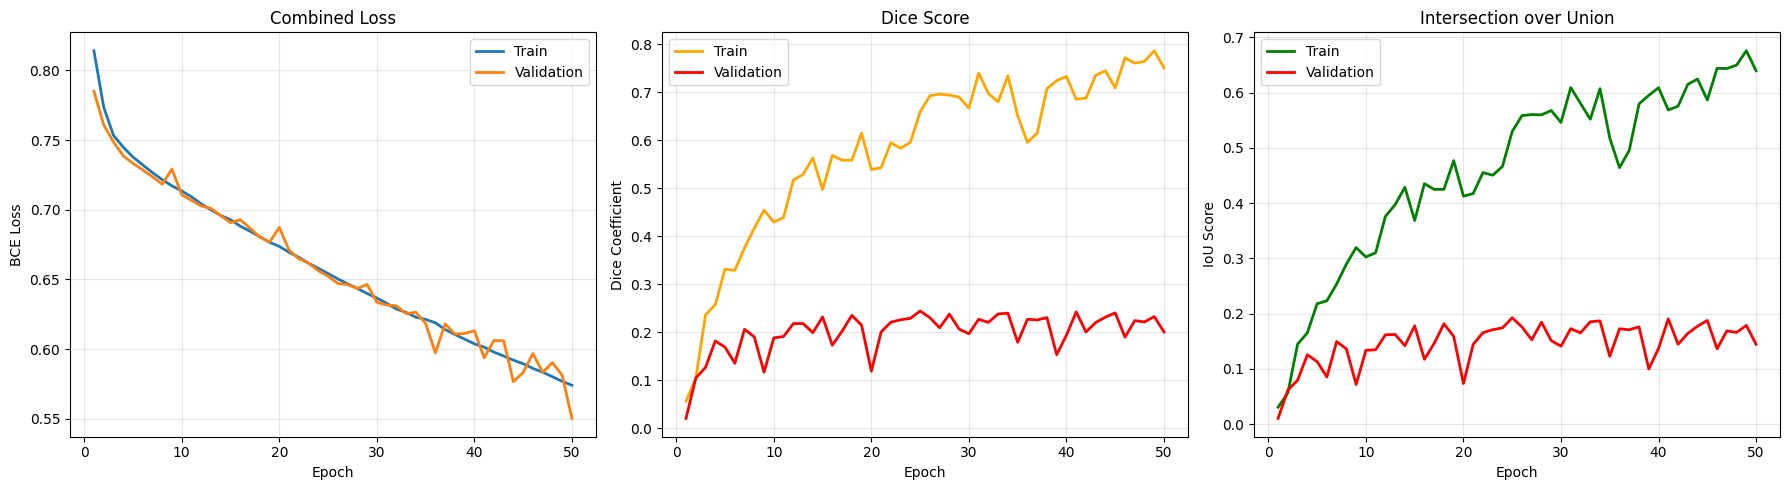

In [213]:
def plot_training_curves(history):
    """Plot training and validation curves"""
    epochs = range(1, len(history['train_loss']) + 1)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # BCE Loss
    axes[0].plot(epochs, history['train_loss'], label='Train', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], label='Validation', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('BCE Loss')
    axes[0].set_title('Combined Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Dice Score
    axes[1].plot(epochs, history['train_dice'], label='Train', linewidth=2, color='orange')
    axes[1].plot(epochs, history['val_dice'], label='Validation', linewidth=2, color='red')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Dice Coefficient')
    axes[1].set_title('Dice Score')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # IoU Score
    axes[2].plot(epochs, history['train_iou'], label='Train', linewidth=2, color='green')
    axes[2].plot(epochs, history['val_iou'], label='Validation', linewidth=2, color='red')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('IoU Score')
    axes[2].set_title('Intersection over Union')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_curves(history)

# Classification from Segmentation Masks

In [214]:
def classify_from_mask(mask_pred, mask_true, threshold=0.5, epsilon=1e-7):

    pred_binary = (mask_pred > threshold).float()
    true_binary = (mask_true > threshold).float()

    # Compute Dice coefficient
    intersection = (pred_binary * true_binary).sum().item()
    pred_sum = pred_binary.sum().item()  # Count of pixels with value 1
    true_sum = true_binary.sum().item()

    dice = (2.0 * intersection) / (pred_sum + true_sum + epsilon)

    # Compute IoU
    union = pred_sum + true_sum - intersection
    iou = intersection / (union + epsilon)


    predicted_class = 1 if pred_sum > 0 else 0

    return predicted_class, dice, iou

In [215]:
def evaluate_segmentation_and_classification(model, dataloader, split_name="Test"):
    """
    Evaluate both segmentation and classification.
    Classification is derived from segmentation quality (Dice/IoU scores).
    """
    model.eval()

    # Segmentation metrics
    all_seg_preds = []
    all_seg_true = []

    # Classification metrics
    all_clf_preds = []
    all_clf_true = []

    # Per-sample metrics for analysis
    all_dice_scores = []
    all_iou_scores = []

    print("\n" + "="*70)
    print(f"🔍 EVALUATING ON {split_name.upper()} SET")
    print("="*70)
    print("Classification based on: Segmentation probabilities [0, 1] from sigmoid")
    print("Metrics computed: Dice & IoU for each sample\n")

    with torch.no_grad():
        for images, masks, clf_labels in tqdm(dataloader, desc=f"Evaluating {split_name}"):
            images = images.to(device)

            # Stage 1: Segmentation
            seg_logits = model(images)
            seg_probs = torch.sigmoid(seg_logits)

            # Store segmentation predictions
            all_seg_preds.append(seg_probs.cpu())
            all_seg_true.append(masks.cpu())

            # Stage 2: Classification from segmentation quality
            for i in range(seg_probs.size(0)):
                # Compute classification using Dice/IoU
                pred_label, dice, iou = classify_from_mask(
                    seg_probs[i].cpu(),
                    masks[i].cpu()
                )
                true_label = clf_labels[i].item()

                all_clf_preds.append(pred_label)
                all_clf_true.append(true_label)
                all_dice_scores.append(dice)
                all_iou_scores.append(iou)

    # Concatenate segmentation results
    seg_preds = torch.cat(all_seg_preds, dim=0)
    seg_true = torch.cat(all_seg_true, dim=0)

    # ===============================
    # SEGMENTATION METRICS
    # ===============================
    pred_binary = (seg_preds > 0.5).float()
    true_binary = (seg_true > 0.5).float()

    pred_flat = pred_binary.view(-1)
    true_flat = true_binary.view(-1)

    TP = (pred_flat * true_flat).sum().item()
    FP = (pred_flat * (1 - true_flat)).sum().item()
    FN = ((1 - pred_flat) * true_flat).sum().item()
    TN = ((1 - pred_flat) * (1 - true_flat)).sum().item()

    epsilon = 1e-7

    iou = TP / (TP + FP + FN + epsilon)
    dice = (2 * TP) / (2 * TP + FP + FN + epsilon)
    pixel_acc = (TP + TN) / (TP + TN + FP + FN + epsilon)
    sensitivity = TP / (TP + FN + epsilon)
    specificity = TN / (TN + FP + epsilon)
    precision = TP / (TP + FP + epsilon)

    # Compute BCE loss
    bce_loss = seg_criterion(torch.logit(seg_preds.clamp(epsilon, 1-epsilon)), seg_true).item()

    seg_metrics = {
        'IoU': iou,
        'Dice': dice,
        'BCE_Loss': bce_loss,
        'Pixel_Accuracy': pixel_acc,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision
    }

    print("\n" + "🎯 SEGMENTATION METRICS ".center(70, "="))
    print(f"  Dice Coefficient: {seg_metrics['Dice']:.4f}")
    print(f"  IoU Score: {seg_metrics['IoU']:.4f}")
    print(f"  BCE Loss: {seg_metrics['BCE_Loss']:.4f}")
    print(f"  Pixel Accuracy: {seg_metrics['Pixel_Accuracy']:.4f}")
    print(f"  Sensitivity (Recall): {seg_metrics['Sensitivity']:.4f}")
    print(f"  Specificity: {seg_metrics['Specificity']:.4f}")
    print(f"  Precision: {seg_metrics['Precision']:.4f}")

    # ===============================
    # CLASSIFICATION METRICS
    # ===============================
    all_clf_preds = np.array(all_clf_preds)
    all_clf_true = np.array(all_clf_true)
    all_dice_scores = np.array(all_dice_scores)
    all_iou_scores = np.array(all_iou_scores)

    # Confusion matrix
    TP_clf = np.sum((all_clf_preds == 1) & (all_clf_true == 1))
    TN_clf = np.sum((all_clf_preds == 0) & (all_clf_true == 0))
    FP_clf = np.sum((all_clf_preds == 1) & (all_clf_true == 0))
    FN_clf = np.sum((all_clf_preds == 0) & (all_clf_true == 1))

    cm = np.array([[TN_clf, FP_clf], [FN_clf, TP_clf]])

    accuracy = (TP_clf + TN_clf) / (TP_clf + TN_clf + FP_clf + FN_clf + epsilon)
    precision_clf = TP_clf / (TP_clf + FP_clf + epsilon)
    recall_clf = TP_clf / (TP_clf + FN_clf + epsilon)
    f1_score = 2 * (precision_clf * recall_clf) / (precision_clf + recall_clf + epsilon)

    # Average Dice/IoU for each classification outcome
    tp_indices = (all_clf_preds == 1) & (all_clf_true == 1)
    tn_indices = (all_clf_preds == 0) & (all_clf_true == 0)
    fp_indices = (all_clf_preds == 1) & (all_clf_true == 0)
    fn_indices = (all_clf_preds == 0) & (all_clf_true == 1)

    avg_dice_tp = all_dice_scores[tp_indices].mean() if tp_indices.sum() > 0 else 0
    avg_dice_tn = all_dice_scores[tn_indices].mean() if tn_indices.sum() > 0 else 0
    avg_dice_fp = all_dice_scores[fp_indices].mean() if fp_indices.sum() > 0 else 0
    avg_dice_fn = all_dice_scores[fn_indices].mean() if fn_indices.sum() > 0 else 0

    clf_metrics = {
        'Confusion_Matrix': cm,
        'Accuracy': accuracy,
        'Precision': precision_clf,
        'Recall': recall_clf,
        'F1_Score': f1_score,
        'Avg_Dice_TP': avg_dice_tp,
        'Avg_Dice_TN': avg_dice_tn,
        'Avg_Dice_FP': avg_dice_fp,
        'Avg_Dice_FN': avg_dice_fn,
        'Mean_Dice': all_dice_scores.mean(),
        'Mean_IoU': all_iou_scores.mean()
    }

    print("\n" + "🎯 CLASSIFICATION METRICS (from Seg Probs [0,1]) ".center(70, "="))
    print(f"  Accuracy: {clf_metrics['Accuracy']:.4f}")
    print(f"  Precision: {clf_metrics['Precision']:.4f}")
    print(f"  Recall: {clf_metrics['Recall']:.4f}")
    print(f"  F1-Score: {clf_metrics['F1_Score']:.4f}")
    print(f"\n  Per-Sample Metrics:")
    print(f"    Mean Dice: {clf_metrics['Mean_Dice']:.4f}")
    print(f"    Mean IoU: {clf_metrics['Mean_IoU']:.4f}")
    print(f"\n  Average Dice by Classification:")
    print(f"    True Positives (TP): {avg_dice_tp:.4f}")
    print(f"    True Negatives (TN): {avg_dice_tn:.4f}")
    print(f"    False Positives (FP): {avg_dice_fp:.4f}")
    print(f"    False Negatives (FN): {avg_dice_fn:.4f}")

    # Plot Confusion Matrix
    print("\n" + "📊 CONFUSION MATRIX ".center(70, "="))

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, cmap='Blues', interpolation='nearest')

    plt.colorbar(im, ax=ax)

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['No Tumor', 'Tumor'])
    ax.set_yticklabels(['No Tumor', 'Tumor'])

    # Add text annotations
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, int(cm[i, j]),
                          ha="center", va="center",
                          color="white" if cm[i, j] > cm.max()/2 else "black",
                          fontsize=16, fontweight='bold')

    ax.set_title(f"Classification from Segmentation Probabilities [0,1] ({split_name})\nAccuracy: {clf_metrics['Accuracy']:.3f} | Mean Dice: {clf_metrics['Mean_Dice']:.3f}",
                 fontsize=14, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    print("\n" + "="*70 + "\n")

    return seg_metrics, clf_metrics

# Show predictions

In [216]:
#Inspect what the loader yields
batch = next(iter(train_loader))
print(type(batch))
print(len(batch))

<class 'list'>
3


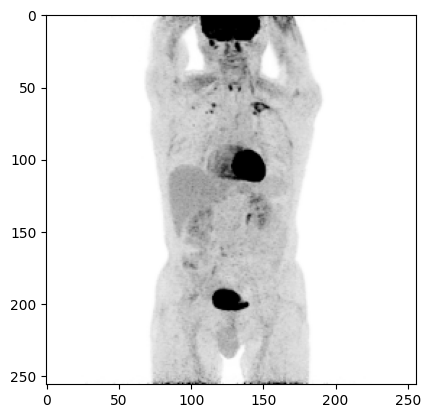

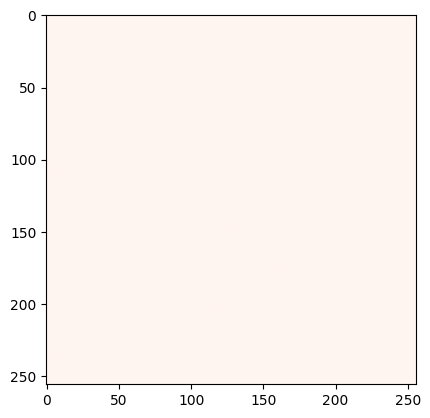

In [217]:
# Display image and label.
train_features, train_labels, _ = next(iter(train_loader))
#print(f"Feature batch shape: {train_features.size()}")
#print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0].squeeze()
plt.imshow(img, cmap="gray")
plt.show()
plt.imshow(label, cmap="Reds")
plt.show()
#print(f"Label: {label}")

In [218]:
def predict(model, image, device):
    model.eval()

    # Ensure correct shape
    if len(image.shape) == 2:
        image = image.unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
    elif len(image.shape) == 3:
        image = image.unsqueeze(0)  # Add batch dim

    image = image.to(device)

    with torch.no_grad():
        output = model(image)

        # Get final output if deep supervision
        if isinstance(output, list):
            output = output[-1]

        # Get probabilities
        probs = torch.sigmoid(output)
        tumor_prob = probs
        pred_mask = (tumor_prob > 0.5).float()

    return pred_mask.squeeze().cpu(), tumor_prob.squeeze().cpu()

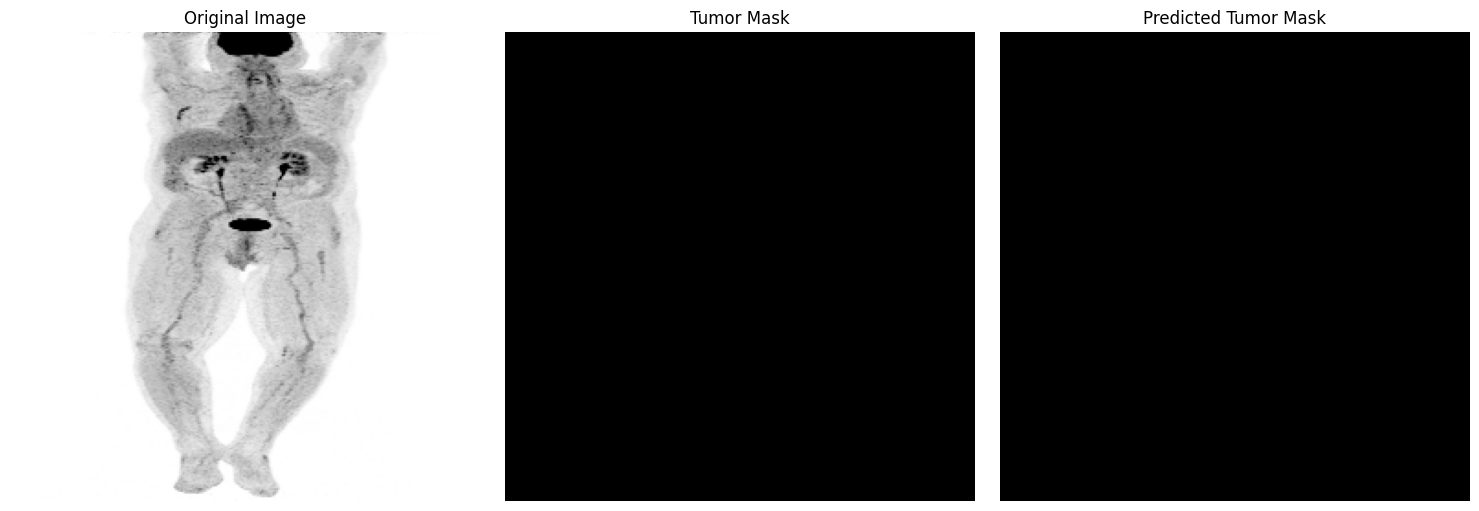

In [220]:
train_features, train_labels, _ = next(iter(train_loader))

pred_mask, _ = predict(transunet, train_features[0].squeeze(), device)

# Visualize prediction
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(train_features[0].squeeze(), cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(train_labels[0].squeeze(), cmap='gray')
axes[1].set_title('Tumor Mask')
axes[1].axis('off')

axes[2].imshow(pred_mask, cmap='gray')
axes[2].set_title('Predicted Tumor Mask')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('prediction_result.png', dpi=300, bbox_inches='tight')
plt.show()

In [221]:
def classify_from_mask(mask_pred, mask_true, threshold=0.5, epsilon=1e-7):
    """
    Classify image based on segmentation probabilities [0, 1].

    Classification logic:
    - If ANY pixel >= threshold (0.5) in predicted mask → Tumor (1)
    - If NO pixels >= threshold → Healthy (0)

    Also computes Dice and IoU metrics for analysis.

    Args:
        mask_pred: Predicted segmentation probabilities [0, 1] (after sigmoid)
        mask_true: Ground truth mask [0, 1]
        threshold: Threshold for binarizing masks (default 0.5)
        epsilon: Small constant for numerical stability

    Returns:
        predicted_class: 1 if any tumor pixel detected, 0 otherwise
        dice_score: Dice coefficient for this prediction
        iou_score: IoU for this prediction
    """
    # Binarize masks at threshold 0.5
    # mask_pred already contains probabilities [0,1] from sigmoid
    # Pixels with prob ≥ 0.5 become 1, pixels < 0.5 become 0
    pred_binary = (mask_pred > threshold).float()
    true_binary = (mask_true > threshold).float()

    # Compute Dice coefficient
    intersection = (pred_binary * true_binary).sum().item()
    pred_sum = pred_binary.sum().item()  # Count of pixels with value 1
    true_sum = true_binary.sum().item()

    dice = (2.0 * intersection) / (pred_sum + true_sum + epsilon)

    # Compute IoU
    union = pred_sum + true_sum - intersection
    iou = intersection / (union + epsilon)

    # Classification: If ANY pixel == 1 (after thresholding) → Tumor
    # If ALL pixels == 0 → Healthy
    predicted_class = 1 if pred_sum > 0 else 0

    return predicted_class, dice, iou

In [209]:
# import numpy as np
# import scipy.ndimage as ndi
# from skimage.measure import label, regionprops

# def predict_label_from_mask(prob_mask, prob_thres=0.5, min_area = 30):
#   bin_mask = (prob_mask >= prob_thres).astype(np.uint8)
#   if bin_mask.sum() == 0:
#     return 0, bin_mask

#   labeled = label(bin_mask)
#   regions = regionprops(labeled)
#   keep = np.zeros_like(bin_mask)
#   for r in regions:
#     if r.area >= min_area:
#       keep[labeled == r.label] = 1

#   if keep.sum() == 0:
#     return 0, keep

#   return 1, keep


In [210]:
# import numpy as np
# from skimage.measure import label, regionprops

# def classify_from_mask_clean(mask_pred, mask_true, threshold=0.5, min_area=30, epsilon=1e-7):
#     """
#     Improved classification based on segmentation masks.
#     Includes:
#       • thresholding
#       • removal of small noisy blobs (min_area)
#       • proper Dice/IoU for empty masks
#     """
#     # Convert tensors to numpy
#     mask_pred = mask_pred.squeeze().numpy()
#     mask_true = mask_true.squeeze().numpy()

#     # Threshold predicted & true masks
#     pred_binary = (mask_pred > threshold).astype(np.uint8)
#     true_binary = (mask_true > threshold).astype(np.uint8)

#     # ---- REMOVE SMALL FALSE-POSITIVE BLOBS ----
#     labeled = label(pred_binary)
#     cleaned = np.zeros_like(pred_binary)

#     for region in regionprops(labeled):
#         if region.area >= min_area:      # keep only real-sized blobs
#             cleaned[labeled == region.label] = 1

#     pred_binary = cleaned

#     # ---- CLASSIFICATION ----
#     predicted_class = 1 if pred_binary.sum() > 0 else 0

#     # ---- DICE + IOU (with proper empty-mask handling) ----
#     pred_sum = pred_binary.sum()
#     true_sum = true_binary.sum()
#     intersection = (pred_binary * true_binary).sum()

#     if true_sum == 0 and pred_sum == 0:
#         dice = 1.0
#         iou = 1.0
#     else:
#         dice = (2 * intersection) / (pred_sum + true_sum + epsilon)
#         union = pred_sum + true_sum - intersection
#         iou = intersection / (union + epsilon)

#     return predicted_class, dice, iou

In [222]:
def evaluate_segmentation_and_classification(model, dataloader, split_name="Test"):
    """
    Evaluate both segmentation and classification.
    Classification is derived from segmentation quality (Dice/IoU scores).
    """
    model.eval()

    # Segmentation metrics
    all_seg_preds = []
    all_seg_true = []

    # Classification metrics
    all_clf_preds = []
    all_clf_true = []

    # Per-sample metrics for analysis
    all_dice_scores = []
    all_iou_scores = []

    print("\n" + "="*70)
    print(f"🔍 EVALUATING ON {split_name.upper()} SET")
    print("="*70)
    print("Classification based on: Segmentation probabilities [0, 1] from sigmoid")
    print("Metrics computed: Dice & IoU for each sample\n")

    with torch.no_grad():
        for images, masks, clf_labels in tqdm(dataloader, desc=f"Evaluating {split_name}"):
            images = images.to(device)

            # Stage 1: Segmentation
            seg_logits = model(images)        # Raw outputs: [-∞, +∞]
            seg_probs = torch.sigmoid(seg_logits)  # Probabilities: [0, 1]

            # Store segmentation predictions
            all_seg_preds.append(seg_probs.cpu())
            all_seg_true.append(masks.cpu())

            # Stage 2: Classification from segmentation quality
            for i in range(seg_probs.size(0)):
                # Compute classification using Dice/IoU
                pred_label, dice, iou = classify_from_mask(
                    seg_probs[i].cpu(),
                    masks[i].cpu()
                )

                # pred_label, dice, iou = classify_from_mask_clean(
                #   seg_probs[i].cpu(),
                #   masks[i].cpu(),
                #   threshold=0.5)
                true_label = clf_labels[i].item()

                all_clf_preds.append(pred_label)
                all_clf_true.append(true_label)
                all_dice_scores.append(dice)
                all_iou_scores.append(iou)

    # Concatenate segmentation results
    seg_preds = torch.cat(all_seg_preds, dim=0)
    seg_true = torch.cat(all_seg_true, dim=0)

    # ===============================
    # SEGMENTATION METRICS
    # ===============================
    pred_binary = (seg_preds > 0.5).float()
    true_binary = (seg_true > 0.5).float()

    pred_flat = pred_binary.view(-1)
    true_flat = true_binary.view(-1)

    TP = (pred_flat * true_flat).sum().item()
    FP = (pred_flat * (1 - true_flat)).sum().item()
    FN = ((1 - pred_flat) * true_flat).sum().item()
    TN = ((1 - pred_flat) * (1 - true_flat)).sum().item()

    epsilon = 1e-7

    iou = TP / (TP + FP + FN + epsilon)
    dice = (2 * TP) / (2 * TP + FP + FN + epsilon)
    pixel_acc = (TP + TN) / (TP + TN + FP + FN + epsilon)
    sensitivity = TP / (TP + FN + epsilon)
    specificity = TN / (TN + FP + epsilon)
    precision = TP / (TP + FP + epsilon)

    # Compute BCE loss
    bce_loss = seg_criterion(torch.logit(seg_preds.clamp(epsilon, 1-epsilon)), seg_true).item()

    seg_metrics = {
        'IoU': iou,
        'Dice': dice,
        'BCE_Loss': bce_loss,
        'Pixel_Accuracy': pixel_acc,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision
    }

    print("\n" + "🎯 SEGMENTATION METRICS ".center(70, "="))
    print(f"  Dice Coefficient: {seg_metrics['Dice']:.4f}")
    print(f"  IoU Score: {seg_metrics['IoU']:.4f}")
    print(f"  BCE Loss: {seg_metrics['BCE_Loss']:.4f}")
    print(f"  Pixel Accuracy: {seg_metrics['Pixel_Accuracy']:.4f}")
    print(f"  Sensitivity (Recall): {seg_metrics['Sensitivity']:.4f}")
    print(f"  Specificity: {seg_metrics['Specificity']:.4f}")
    print(f"  Precision: {seg_metrics['Precision']:.4f}")

    # ===============================
    # CLASSIFICATION METRICS
    # ===============================
    all_clf_preds = np.array(all_clf_preds)
    all_clf_true = np.array(all_clf_true)
    all_dice_scores = np.array(all_dice_scores)
    all_iou_scores = np.array(all_iou_scores)

    # Confusion matrix
    TP_clf = np.sum((all_clf_preds == 1) & (all_clf_true == 1))
    TN_clf = np.sum((all_clf_preds == 0) & (all_clf_true == 0))
    FP_clf = np.sum((all_clf_preds == 1) & (all_clf_true == 0))
    FN_clf = np.sum((all_clf_preds == 0) & (all_clf_true == 1))

    cm = np.array([[TN_clf, FP_clf], [FN_clf, TP_clf]])

    accuracy = (TP_clf + TN_clf) / (TP_clf + TN_clf + FP_clf + FN_clf + epsilon)
    precision_clf = TP_clf / (TP_clf + FP_clf + epsilon)
    recall_clf = TP_clf / (TP_clf + FN_clf + epsilon)
    f1_score = 2 * (precision_clf * recall_clf) / (precision_clf + recall_clf + epsilon)

    # Average Dice/IoU for each classification outcome
    tp_indices = (all_clf_preds == 1) & (all_clf_true == 1)
    tn_indices = (all_clf_preds == 0) & (all_clf_true == 0)
    fp_indices = (all_clf_preds == 1) & (all_clf_true == 0)
    fn_indices = (all_clf_preds == 0) & (all_clf_true == 1)

    avg_dice_tp = all_dice_scores[tp_indices].mean() if tp_indices.sum() > 0 else 0
    avg_dice_tn = all_dice_scores[tn_indices].mean() if tn_indices.sum() > 0 else 0
    avg_dice_fp = all_dice_scores[fp_indices].mean() if fp_indices.sum() > 0 else 0
    avg_dice_fn = all_dice_scores[fn_indices].mean() if fn_indices.sum() > 0 else 0

    clf_metrics = {
        'Confusion_Matrix': cm,
        'Accuracy': accuracy,
        'Precision': precision_clf,
        'Recall': recall_clf,
        'F1_Score': f1_score,
        'Avg_Dice_TP': avg_dice_tp,
        'Avg_Dice_TN': avg_dice_tn,
        'Avg_Dice_FP': avg_dice_fp,
        'Avg_Dice_FN': avg_dice_fn,
        'Mean_Dice': all_dice_scores.mean(),
        'Mean_IoU': all_iou_scores.mean()
    }

    print("\n" + "🎯 CLASSIFICATION METRICS (from Seg Probs [0,1]) ".center(70, "="))
    print(f"  Accuracy: {clf_metrics['Accuracy']:.4f}")
    print(f"  Precision: {clf_metrics['Precision']:.4f}")
    print(f"  Recall: {clf_metrics['Recall']:.4f}")
    print(f"  F1-Score: {clf_metrics['F1_Score']:.4f}")
    print(f"\n  Per-Sample Metrics:")
    print(f"    Mean Dice: {clf_metrics['Mean_Dice']:.4f}")
    print(f"    Mean IoU: {clf_metrics['Mean_IoU']:.4f}")
    print(f"\n  Average Dice by Classification:")
    print(f"    True Positives (TP): {avg_dice_tp:.4f}")
    print(f"    True Negatives (TN): {avg_dice_tn:.4f}")
    print(f"    False Positives (FP): {avg_dice_fp:.4f}")
    print(f"    False Negatives (FN): {avg_dice_fn:.4f}")

    # Plot Confusion Matrix
    print("\n" + "📊 CONFUSION MATRIX ".center(70, "="))

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, cmap='Blues', interpolation='nearest')

    plt.colorbar(im, ax=ax)

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['No Tumor', 'Tumor'])
    ax.set_yticklabels(['No Tumor', 'Tumor'])

    # Add text annotations
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, int(cm[i, j]),
                          ha="center", va="center",
                          color="white" if cm[i, j] > cm.max()/2 else "black",
                          fontsize=16, fontweight='bold')

    ax.set_title(f"Classification from Segmentation Probabilities [0,1] ({split_name})\nAccuracy: {clf_metrics['Accuracy']:.3f} | Mean Dice: {clf_metrics['Mean_Dice']:.3f}",
                 fontsize=14, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    print("\n" + "="*70 + "\n")

    return seg_metrics, clf_metrics


🔍 EVALUATING ON TEST SET
Classification based on: Segmentation probabilities [0, 1] from sigmoid
Metrics computed: Dice & IoU for each sample



Evaluating Test: 100%|██████████| 12/12 [00:02<00:00,  4.54it/s]



=======================🎯 SEGMENTATION METRICS ========================
  Dice Coefficient: 0.5588
  IoU Score: 0.3877
  BCE Loss: 0.6555
  Pixel Accuracy: 0.9954
  Sensitivity (Recall): 0.7538
  Specificity: 0.9964
  Precision: 0.4440

===========🎯 CLASSIFICATION METRICS (from Seg Probs [0,1]) ===========
  Accuracy: 0.7391
  Precision: 0.5385
  Recall: 1.0000
  F1-Score: 0.7000

  Per-Sample Metrics:
    Mean Dice: 0.1973
    Mean IoU: 0.1540

  Average Dice by Classification:
    True Positives (TP): 0.6483
    True Negatives (TN): 0.0000
    False Positives (FP): 0.0000
    False Negatives (FN): 0.0000

=========================📊 CONFUSION MATRIX ==========================


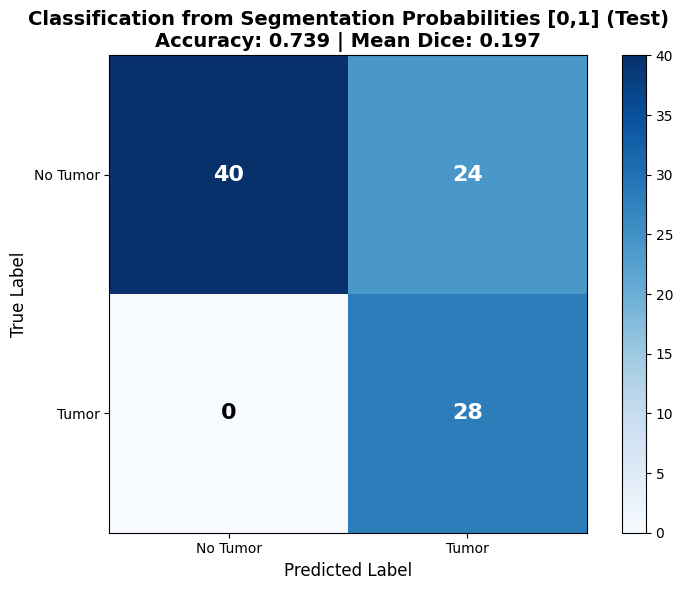

In [223]:
#Evaluate on test set
test_seg_metrics, test_clf_metrics = evaluate_segmentation_and_classification(
    transunet, test_loader, split_name="Test"
)